In [ ]:
!pip install keras-tuner

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, GlobalAveragePooling3D, LSTM, Embedding, Activation, Flatten, AveragePooling1D, BatchNormalization, Reshape, Concatenate, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
# from keras.metrics import Recall, Precision, F1Score, Accuracy, categorical_accuracy
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
# !pip install tensorflow-addons
# import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision, F1Score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
from gensim.models import Word2Vec, fasttext
# from keras.initializers import Constant
# from keras.regularizers import  c
# from nltk.corpus import stopwords
# from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from transformers import pipeline
from tensorboard.plugins.hparams import api as hp
import keras_tuner as kt

# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import keras
import pickle
import os
import json
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


# Loading Data

In [ ]:
# npt_stop = pd.read_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Data/readyToTrain/no_postag_with_stopwords/no_postag_with_stopwords.csv")
# npt_nostop = pd.read_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Data/readyToTrain/no_postag_without_stopwords/no_postag_without_stopwords.csv")
# pt_stop = pd.read_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Data/readyToTrain/postag_with_stopwords/postag_with_stopwords.csv")
pt_nonstop = pd.read_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Data/readyToTrain/postag_without_stopwords/postag_without_stopwords.csv")
pt_nonstop["Tweet"].fillna("", inplace=True)
clearDf = pt_nonstop.copy()
max_token_sentence = max([len(text.split()) for text in clearDf["Tweet"]])
num_of_long_sentences = len([len(text.split()) for text in clearDf["Tweet"] if len(text.split())>100])
max_token_sentence
index_long_sentence = [i for i, text in enumerate(clearDf["Tweet"]) if len(text.split())>100]
clearDf.drop(index_long_sentence, axis = 0, inplace = True)

In [ ]:
embedding_matrix = np.load("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Data/readyToTrain/postag_without_stopwords/embedding_matrix.npy")

In [ ]:

# saving
# with open('ft_tokenizer.pickle', 'wb') as handle:
#     pickle.dump(ft_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
with open('/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Data/readyToTrain/postag_without_stopwords/ft_tokenizer.pickle', 'rb') as handle:
    ft_tokenizer = pickle.load(handle)

In [ ]:
# encode_text = w2v_tokenizer_fit_to_texts(formalDf["Tweet"]) # Word2Vec Tokenizer
# encode_text[0]
# ft_tokenizer = Tokenizer()
# ft_tokenizer.fit_on_texts(clearDf["Tweet"])
encode_text = ft_tokenizer.texts_to_sequences(clearDf["Tweet"])



In [ ]:
# PARAM FOR EMBEDDING LAYER
max_sen_len = 100  # max sentence of a review
vocab_size = len(ft_tokenizer.index_word)+1  # total number of words
embed_dim = 300
input_dim = vocab_size
output_dim = embed_dim

In [ ]:
# now padding to have a amximum length of 1565
X = pad_sequences(encode_text, maxlen=max_sen_len, padding='pre', value = 0)

# y = formalDf.apply(lambda row : emotions.index(row["Label"]), axis = 1).values.astype("int32") # Label Encoding
encoder = OneHotEncoder(sparse_output = False) #Onehot encoding
y = encoder.fit_transform(clearDf[["Label"]])
lossfun = CategoricalCrossentropy()
# y = encoder.inverse_transform(y)
y

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:
from joblib import dump, load
# dump(encoder, 'encoder.joblib') # save the model
clf = load('/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Data/readyToTrain/postag_without_stopwords/encoder.joblib') # load and reuse the model

# Split Data

## Split 80 train set, 10 val test, 10 test set

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(
    X, y, random_state = 42, test_size = 0.2, stratify = y
)
train_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
test_df = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1)
train_df.to_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/train_eval.csv", index = False)
test_df.to_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/test.csv", index = False)
pd.DataFrame(X_train).to_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/X_train.csv", index = False)
pd.DataFrame(X_test).to_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/X_test.csv", index = False)
pd.DataFrame(y_train).to_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/y_train.csv", index = False)
pd.DataFrame(y_test).to_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/y_test.csv", index = False)

## Split 50% Train val, 50% K-fold crossval

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(
    X, y, random_state = 42, test_size = 0.5, stratify = y
)
train_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
test_df = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1)

train_df.to_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/dev50-kfold50/train.csv", index = False)
test_df.to_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/dev50-kfold50/test.csv", index = False)



# Metaparams

In [ ]:

metrics = [
    'accuracy',
]

# metrics2 = [
#     'accuracy',
# ]
optimizer = keras.optimizers.legacy.Adam(learning_rate = 0.0001)
loss = CategoricalCrossentropy()


# Models Arch + Tuning setup

In [ ]:
class LSTMModel(kt.HyperModel):
  def build(self, hp):
      model = Sequential()
      # model.add(Embedding(input_dim = input_dim, output_dim = output_dim, weights = [w2v_model.wv.vectors], input_length = max_rev_len, trainable = False, mask_zero = True, embeddings_regularizer=l2(.01)))
      model.add(Embedding(input_dim = input_dim, output_dim = output_dim, weights = [embedding_matrix], input_length = max_sen_len, trainable = False))

      hp_lstm_units = hp.Choice('lstm_unit', [32, 64, 128, 256])
      hp_dropout_lstm = hp.Choice('dropout_rate', [.1,.2,.3,.4,.5])
      hp_learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

      model.add(LSTM(hp_lstm_units, dropout=hp_dropout_lstm, return_sequences = False))
      model.add(Dense(6, activation = "softmax"))
      model.compile(
          optimizer= keras.optimizers.legacy.Adam(learning_rate = hp_learning_rate),
          loss = lossfun,
          metrics=['accuracy'],
      )

      return model

  def fit(self, hp, model, *args, **kwargs):
      return model.fit(
          *args,
          batch_size=hp.Choice("batch_size", [64, 128, 256]),
          **kwargs,
      )


In [ ]:
class CNNLSTMModel(kt.HyperModel):
  def build(self, hp) :
      hp_num_of_kernel = hp.Choice('num_of_kernel', [32,64,128,256])
      hp_lstm_units = hp.Choice('lstm_unit', [32, 64, 128, 256])
      hp_kernel_size = hp.Choice('kernel_size', [1,2])
      hp_dropout_rate = hp.Choice('dropout_rate', [.1,.2,.3,.4,.5])
      hp_learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")


      input_layer = Input(shape = (max_sen_len,))
      embedding_layer = Embedding(input_dim = input_dim, output_dim = output_dim, weights = [embedding_matrix], input_length = max_sen_len, trainable = False)(input_layer)
      def add_conv_layer(filter_size):
          return Conv1D(filters=hp_num_of_kernel, kernel_size=filter_size, activation='relu', padding='same')(embedding_layer)

      list_conv_layer = []

      with hp.conditional_scope("kernel_size", 1):
        if hp_kernel_size == 1:
          for ks in [4,6,8] :
            list_conv_layer.append(add_conv_layer(ks))
      with hp.conditional_scope("kernel_size", 2):
        if hp_kernel_size == 2:
          for ks in [6,8,10] :
            list_conv_layer.append(add_conv_layer(ks))

      # Concatenate the outputs of the three Conv1D layers
      concatenate = Concatenate(axis=-1)(list_conv_layer)
      dropout = Dropout(hp_dropout_rate)(concatenate)
      pooling_layer = MaxPool1D()(dropout)
      dropout = Dropout(hp_dropout_rate)(pooling_layer)
      # model.add(BatchNormalization())
      # model.add(Dropout(hp_dropout_rate))
      lstm = LSTM(hp_lstm_units, dropout = hp_dropout_rate, return_sequences = False)(dropout)
      # dropout = Dropout(hp_dropout_rate)(lstm)
      # output_layer = Dense(6)(lstm)
      output_layer = Dense(6, activation='softmax')(lstm)
      model = Model(inputs = input_layer, outputs = output_layer)
      model.compile(
          optimizer= keras.optimizers.legacy.Adam(learning_rate = hp_learning_rate),
          loss = lossfun,
          metrics=['accuracy'],
      )
      return model
  def fit(self, hp, model, *args, **kwargs):
    return model.fit(
        *args,
          batch_size = hp.Choice("batch_size", [32, 64, 128, 256]),
        **kwargs,
    )


In [ ]:
def c1lstm_builder(hp):
    model = Sequential()
    # model.add(Embedding(input_dim = input_dim, output_dim = output_dim, weights = [w2v_model.wv.vectors], input_length = max_rev_len, trainable = False, mask_zero = True, embeddings_regularizer=l2(.01)))
    model.add(Embedding(input_dim = input_dim, output_dim = output_dim, weights = [embedding_matrix], input_length = max_sen_len, trainable = False))

    hp_lstm_units = hp.Choice('lstm_unit', [32, 64, 128, 256, 512])
    hp_dropout_lstm = hp.Choice('dropout_rate', [.3,.4,.5])
    hp_learning_rate = hp.Choice("lr",[.001, .0001])
    hp_num_of_kernel = hp.Choice('num_of_kernel', [32,64,128,256])
    hp_kernel_size = hp.Choice('kernel_size', [4,6,8,10])
    hp_pooling_layer = hp.Choice('pooling_layer', ['avg', "max"])


    model.add(Conv1D(filters=hp_num_of_kernel, kernel_size=hp_kernel_size, activation='relu', padding='same'))
    with hp.conditional_scope("pooling_layer", 'avg'):
      if hp_pooling_layer == 'avg':
        model.add(AveragePooling1D())
    with hp.conditional_scope("pooling_layer", 'max'):
      if hp_pooling_layer == 'mac':
        model.add(MaxPool1D())
    model.add(LSTM(hp_lstm_units, dropout=hp_dropout_lstm, return_sequences = False))
    model.add(Dense(6, activation = "softmax"))
    model.compile(
        optimizer= keras.optimizers.legacy.Adam(learning_rate = hp_learning_rate),
        loss = lossfun,
        metrics=['accuracy'],
    )

    return model

# 80 20 split

##Loading Data 80 20

In [ ]:
X_test = pd.read_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/X_test.csv")
X_train = pd.read_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/X_train.csv")
y_test = pd.read_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/y_test.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/y_train.csv")

## LSTM

###Training + dev

In [ ]:
lstm_tuner = kt.Hyperband(lstm_builder,
                     objective = 'val_loss',
                     max_epochs = 30,
                     factor = 3,
                     directory = "/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/tuning",
                     project_name = "lstm")

Reloading Tuner from /content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/tuning/lstm/tuner0.json


In [ ]:
stop_early = EarlyStopping(monitor='val_loss', patience = 5)


In [ ]:
lstm_tuner.search(X_train, y_train, validation_split = 0.2, callbacks = [stop_early])

Trial 90 Complete [00h 00m 35s]
val_loss: 0.8664271831512451

Best val_loss So Far: 0.8410476446151733
Total elapsed time: 00h 22m 43s


In [ ]:
best_hps = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/lstm/bestweights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto"
)

In [ ]:
model = lstm_tuner.hypermodel.build(best_hps)
history = model.fit(X_train,y_train, epochs = 50, callbacks = [stop_early, checkpoint], validation_split = .2)

Epoch 1/50
142/142 [==============================] - 5s 21ms/step - loss: 1.4426 - accuracy: 0.4491 - val_loss: 1.1232 - val_accuracy: 0.6108
Epoch 2/50
142/142 [==============================] - 2s 12ms/step - loss: 1.0322 - accuracy: 0.6333 - val_loss: 0.9703 - val_accuracy: 0.6655
Epoch 3/50
142/142 [==============================] - 2s 13ms/step - loss: 0.9847 - accuracy: 0.6474 - val_loss: 0.9353 - val_accuracy: 0.6770
Epoch 4/50
142/142 [==============================] - 1s 9ms/step - loss: 0.8761 - accuracy: 0.6840 - val_loss: 0.8915 - val_accuracy: 0.6726
Epoch 5/50
142/142 [==============================] - 1s 8ms/step - loss: 0.8093 - accuracy: 0.6991 - val_loss: 0.8861 - val_accuracy: 0.6893
Epoch 6/50
142/142 [==============================] - 1s 8ms/step - loss: 0.7818 - accuracy: 0.7209 - val_loss: 0.8765 - val_accuracy: 0.6920
Epoch 7/50
142/142 [==============================] - 1s 8ms/step - loss: 0.7357 - accuracy: 0.7322 - val_loss: 0.8913 - val_accuracy: 0.6955
Epo

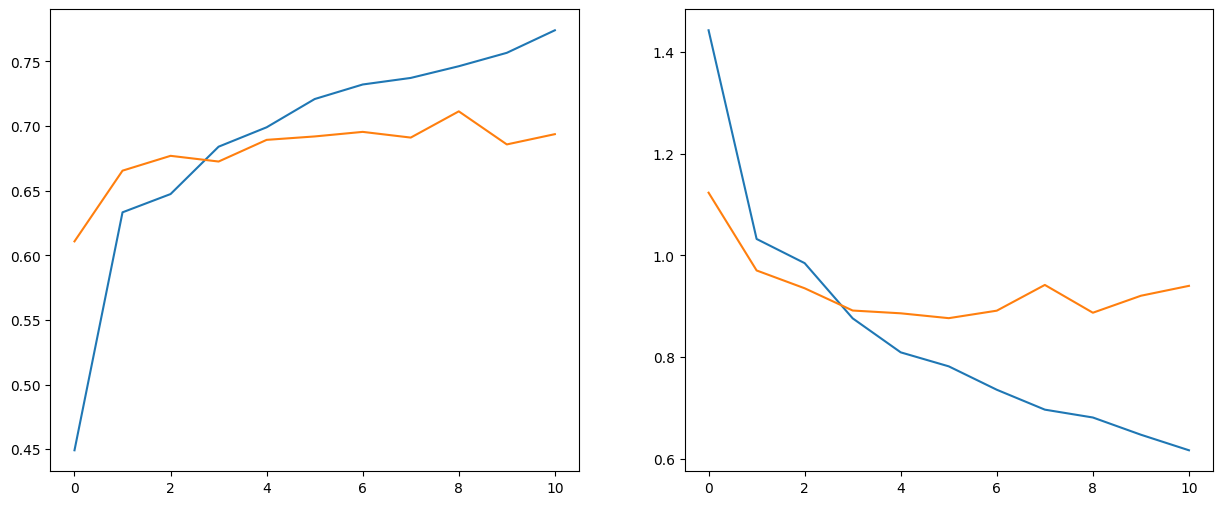

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])

###Evaluate

In [ ]:

model = lstm_tuner.hypermodel.build(best_hps)
model.load_weights("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/lstm/bestweights.h5")
eval_metric = model.evaluate(X_test,y_test.values)
y_pred = model.predict(X_test)
y_pred = [np.argmax(pred) for pred in y_pred]
y_true = [np.argmax(true) for true in y_test.values]
y_true
metric = {}
macro_precision = precision_score(y_true, y_pred, average='macro')
part_precision = precision_score(y_true, y_pred, average = None)
macro_recall = recall_score(y_true, y_pred, average = 'macro')
part_recall = recall_score(y_true, y_pred, average = None)
macro_f1 = f1_score(y_true, y_pred, average = 'macro')
part_f1 = f1_score(y_true, y_pred, average = None)
metrics["macro_precision"] = macro_precision
metrics["macro_recall"] = macro_recall
metrics["macro_f1"] = macro_f1
metrics["part_precision"] = part_precision.tolist()
metrics["part_recall"] = part_recall.tolist()
metrics["part_f1"] = part_f1.tolist()
metrics['loss'] = eval_metric[0]
metrics['accuracy'] = eval_metric[1]

45/45 [==============================] - 1s 7ms/step


In [ ]:
metrics

{}

## CNN-LSTM

###Training + dev

In [ ]:
cnnlstm_tuner = kt.Hyperband(cnn_lstm_builder,
                     objective = 'val_loss',
                     max_epochs = 30,
                     factor = 3,
                     directory = "/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/tuning",
                     project_name = "cnn_lstm")

In [ ]:
stop_early = EarlyStopping(monitor='val_loss', patience = 5)


In [ ]:
cnnlstm_tuner.search(X_train, y_train, epochs=30, validation_split = 0.2, callbacks = [stop_early])

Trial 90 Complete [00h 01m 01s]
val_loss: 0.9401220083236694

Best val_loss So Far: 0.8523857593536377
Total elapsed time: 00h 23m 34s


In [ ]:
best_hps = cnnlstm_tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/cnnlstm/bestweights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto"
)

In [ ]:
model = cnnlstm_tuner.hypermodel.build(best_hps)
history = model.fit(X_train,y_train, epochs = 50, callbacks = [stop_early, checkpoint ], validation_split = .2)

Epoch 1/50
142/142 [==============================] - 5s 16ms/step - loss: 1.4360 - accuracy: 0.4370 - val_loss: 1.0878 - val_accuracy: 0.5896
Epoch 2/50
142/142 [==============================] - 2s 13ms/step - loss: 1.0660 - accuracy: 0.6127 - val_loss: 0.9840 - val_accuracy: 0.6346
Epoch 3/50
142/142 [==============================] - 2s 12ms/step - loss: 0.9615 - accuracy: 0.6443 - val_loss: 0.9352 - val_accuracy: 0.6443
Epoch 4/50
142/142 [==============================] - 2s 11ms/step - loss: 0.9057 - accuracy: 0.6710 - val_loss: 0.9412 - val_accuracy: 0.6558
Epoch 5/50
142/142 [==============================] - 2s 12ms/step - loss: 0.8621 - accuracy: 0.6845 - val_loss: 0.8834 - val_accuracy: 0.6681
Epoch 6/50
142/142 [==============================] - 1s 10ms/step - loss: 0.8215 - accuracy: 0.6988 - val_loss: 0.8721 - val_accuracy: 0.6787
Epoch 7/50
142/142 [==============================] - 1s 10ms/step - loss: 0.7740 - accuracy: 0.7112 - val_loss: 0.8570 - val_accuracy: 0.6805

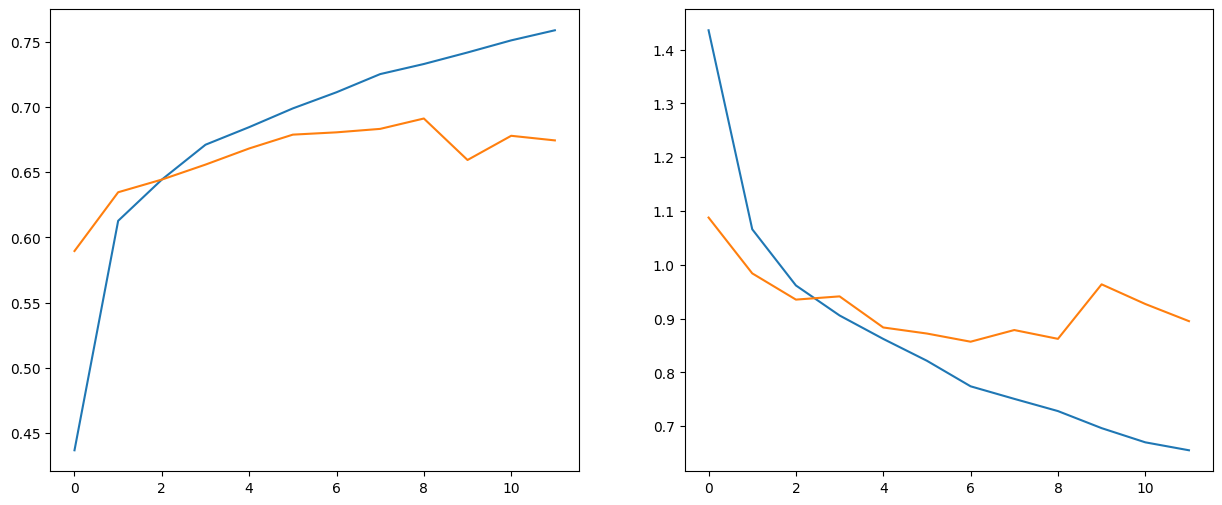

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])

###Evaluate

In [ ]:

model = cnnlstm_tuner.hypermodel.build(best_hps)
model.load_weights("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/cnnlstm/bestweights.h5")
eval_metric = model.evaluate(X_test,y_test.values)
y_pred = model.predict(X_test)
y_pred = [np.argmax(pred) for pred in y_pred]
y_true = [np.argmax(true) for true in y_test.values]
y_true
metrics = {}
macro_precision = precision_score(y_true, y_pred, average='macro')
part_precision = precision_score(y_true, y_pred, average = None)
macro_recall = recall_score(y_true, y_pred, average = 'macro')
part_recall = recall_score(y_true, y_pred, average = None)
macro_f1 = f1_score(y_true, y_pred, average = 'macro')
part_f1 = f1_score(y_true, y_pred, average = None)
metrics["macro_precision"] = macro_precision
metrics["macro_recall"] = macro_recall
metrics["macro_f1"] = macro_f1
metrics["part_precision"] = part_precision.tolist()
metrics["part_recall"] = part_recall.tolist()
metrics["part_f1"] = part_f1.tolist()
metrics['loss'] = eval_metric[0]
metrics['accuracy'] = eval_metric[1]

45/45 [==============================] - 2s 8ms/step


In [ ]:
metrics

{'macro_precision': 0.6967381007602734,
 'macro_recall': 0.7238528989336889,
 'macro_f1': 0.7050101120240577,
 'part_precision': [0.7304347826086957,
  0.7487179487179487,
  0.6610169491525424,
  0.6323529411764706,
  0.6634615384615384,
  0.7444444444444445],
 'part_recall': [0.7433628318584071,
  0.8021978021978022,
  0.7647058823529411,
  0.8486842105263158,
  0.5175,
  0.6666666666666666],
 'part_f1': [0.736842105263158,
  0.7745358090185676,
  0.7090909090909091,
  0.7247191011235954,
  0.5814606741573033,
  0.7034120734908137],
 'loss': 0.8713638186454773,
 'accuracy': 0.6913841962814331}

In [ ]:
with open('/content/drive/MyDrive/Skripsi/Revisi/split80_20/lstm/lstm_performance.json') as json_file:
    data = json.load(json_file)

data

{'macro_precision': 0.6986658181026297,
 'macro_recall': 0.7132266894318757,
 'macro_f1': 0.6950585461173321,
 'part_precision': [0.7593582887700535,
  0.6842105263157895,
  0.7545454545454545,
  0.5882352941176471,
  0.6230366492146597,
  0.782608695652174],
 'part_recall': [0.6283185840707964,
  0.8571428571428571,
  0.6509803921568628,
  0.9210526315789473,
  0.595,
  0.6268656716417911],
 'part_f1': [0.6876513317191283,
  0.7609756097560976,
  0.6989473684210527,
  0.717948717948718,
  0.6086956521739131,
  0.696132596685083],
 'loss': 0.8728103041648865,
 'accuracy': 0.6836158037185669}

## CNN 1 layer + LSTM

In [ ]:
c1lstm_tuner = kt.Hyperband(c1lstm_builder,
                     objective = 'val_loss',
                     max_epochs = 25,
                     factor = 3,
                     directory = "/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/tuning",
                     project_name = "c1lstm")

In [ ]:
stop_early = EarlyStopping(monitor='val_loss', patience = 5)


In [ ]:
c1lstm_tuner.search(X_train, y_train, validation_split = 0.2, callbacks = [stop_early])

Trial 30 Complete [00h 00m 31s]
val_loss: 0.9663127064704895

Best val_loss So Far: 0.8701437711715698
Total elapsed time: 00h 07m 53s


In [ ]:
best_hps = c1lstm_tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/c1lstm/bestweights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto"
)

In [ ]:
model = c1lstm_tuner.hypermodel.build(best_hps)
history = model.fit(X_train,y_train, epochs = 50, callbacks = [stop_early, checkpoint], validation_split = .2)

Epoch 1/50
142/142 [==============================] - 10s 37ms/step - loss: 1.8002 - accuracy: 0.2910 - val_loss: 1.7173 - val_accuracy: 0.2692
Epoch 2/50
142/142 [==============================] - 3s 20ms/step - loss: 1.5907 - accuracy: 0.3716 - val_loss: 1.5798 - val_accuracy: 0.4139
Epoch 3/50
142/142 [==============================] - 3s 18ms/step - loss: 1.2851 - accuracy: 0.5123 - val_loss: 1.1795 - val_accuracy: 0.5428
Epoch 4/50
142/142 [==============================] - 3s 18ms/step - loss: 1.4757 - accuracy: 0.4253 - val_loss: 1.3747 - val_accuracy: 0.4440
Epoch 5/50
142/142 [==============================] - 2s 16ms/step - loss: 1.3274 - accuracy: 0.4858 - val_loss: 1.3526 - val_accuracy: 0.4387
Epoch 6/50
142/142 [==============================] - 3s 21ms/step - loss: 1.1611 - accuracy: 0.5546 - val_loss: 1.0873 - val_accuracy: 0.6090
Epoch 7/50
142/142 [==============================] - 2s 16ms/step - loss: 1.0584 - accuracy: 0.6068 - val_loss: 1.1738 - val_accuracy: 0.582

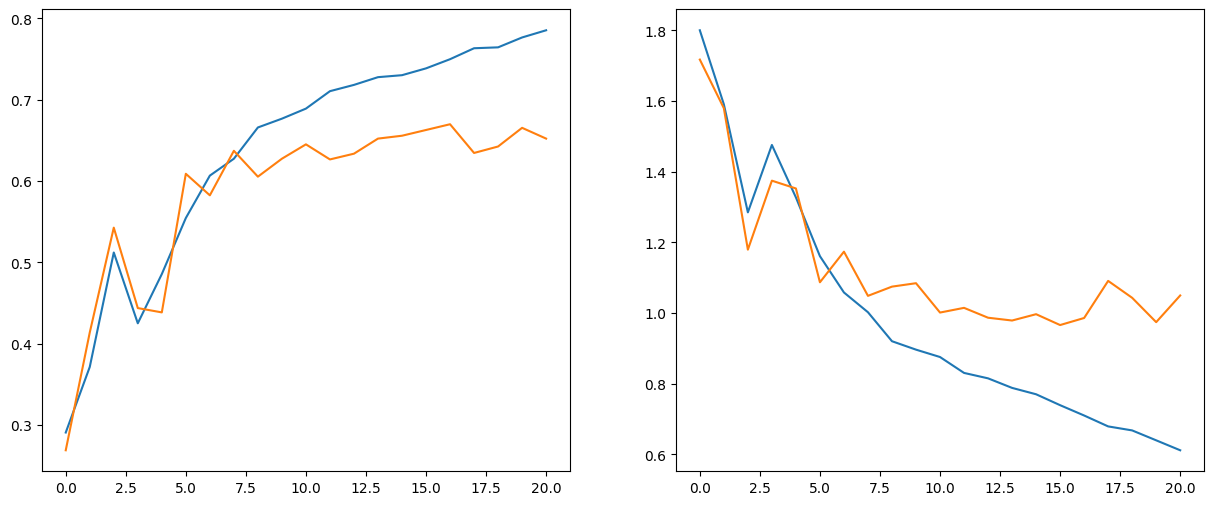

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])

###Evaluate

In [ ]:

model = c1lstm_tuner.hypermodel.build(best_hps)
model.load_weights("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split80_20/c1lstm/bestweights.h5")
eval_metric = model.evaluate(X_test,y_test.values)
y_pred = model.predict(X_test)
y_pred = [np.argmax(pred) for pred in y_pred]
y_true = [np.argmax(true) for true in y_test.values]
y_true
metrics = {}
macro_precision = precision_score(y_true, y_pred, average='macro')
part_precision = precision_score(y_true, y_pred, average = None)
macro_recall = recall_score(y_true, y_pred, average = 'macro')
part_recall = recall_score(y_true, y_pred, average = None)
macro_f1 = f1_score(y_true, y_pred, average = 'macro')
part_f1 = f1_score(y_true, y_pred, average = None)
metrics["macro_precision"] = macro_precision
metrics["macro_recall"] = macro_recall
metrics["macro_f1"] = macro_f1
metrics["part_precision"] = part_precision.tolist()
metrics["part_recall"] = part_recall.tolist()
metrics["part_f1"] = part_f1.tolist()
metrics['loss'] = eval_metric[0]
metrics['accuracy'] = eval_metric[1]

45/45 [==============================] - 1s 7ms/step


In [ ]:
metrics

{'macro_precision': 0.6605090550364907,
 'macro_recall': 0.6965589370036267,
 'macro_f1': 0.6720337924785045,
 'part_precision': [0.7272727272727273,
  0.6609442060085837,
  0.6705882352941176,
  0.6080402010050251,
  0.6610738255033557,
  0.6351351351351351],
 'part_recall': [0.672566371681416,
  0.8461538461538461,
  0.6705882352941176,
  0.7960526315789473,
  0.4925,
  0.7014925373134329],
 'part_f1': [0.6988505747126438,
  0.7421686746987952,
  0.6705882352941176,
  0.6894586894586895,
  0.5644699140401146,
  0.6666666666666666],
 'loss': 0.9745581746101379,
 'accuracy': 0.6610169410705566}

In [ ]:
with open("/content/drive/MyDrive/Skripsi/Revisi/split80_20/c1lstm/performance.json", 'w') as js :
  json.dump(metrics, js)

# 50 50 Cross Validation

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/dev50-kfold50/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/dev50-kfold50/test.csv")
X_train = train_df.iloc[:, :-6].values
y_train = train_df.iloc[:, -6:].values
X_test = test_df.iloc[:, :-6].values
y_test = test_df.iloc[:, -6:].values

## Creating Kfold 30 10

In [ ]:
fold30_index = []
stratifiedKFold = StratifiedKFold(n_splits = 30, random_state = 42, shuffle = True)
for i, (train_index, test_index) in enumerate(stratifiedKFold.split(X_test, y_test.argmax(1))) :
    print(f"{i} - train {len(train_index)} row - test {len(test_index)} row")
    fold30_index.append((train_index, test_index))

0 - train 3421 row - test 118 row
1 - train 3421 row - test 118 row
2 - train 3421 row - test 118 row
3 - train 3421 row - test 118 row
4 - train 3421 row - test 118 row
5 - train 3421 row - test 118 row
6 - train 3421 row - test 118 row
7 - train 3421 row - test 118 row
8 - train 3421 row - test 118 row
9 - train 3421 row - test 118 row
10 - train 3421 row - test 118 row
11 - train 3421 row - test 118 row
12 - train 3421 row - test 118 row
13 - train 3421 row - test 118 row
14 - train 3421 row - test 118 row
15 - train 3421 row - test 118 row
16 - train 3421 row - test 118 row
17 - train 3421 row - test 118 row
18 - train 3421 row - test 118 row
19 - train 3421 row - test 118 row
20 - train 3421 row - test 118 row
21 - train 3421 row - test 118 row
22 - train 3421 row - test 118 row
23 - train 3421 row - test 118 row
24 - train 3421 row - test 118 row
25 - train 3421 row - test 118 row
26 - train 3421 row - test 118 row
27 - train 3421 row - test 118 row
28 - train 3421 row - test 118

In [ ]:
fold10_index = []
stratifiedKFold = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
for i, (train_index, test_index) in enumerate(stratifiedKFold.split(X_test, y_test.argmax(1))) :
    print(f"{i} - train {len(train_index)} row - test {len(test_index)} row")
    fold10_index.append((train_index, test_index))

0 - train 3185 row - test 354 row
1 - train 3185 row - test 354 row
2 - train 3185 row - test 354 row
3 - train 3185 row - test 354 row
4 - train 3185 row - test 354 row
5 - train 3185 row - test 354 row
6 - train 3185 row - test 354 row
7 - train 3185 row - test 354 row
8 - train 3185 row - test 354 row
9 - train 3186 row - test 353 row


In [ ]:
folds30_index = np.array(fold30_index, dtype = object)
np.save("/content/drive/MyDrive/Skripsi/Revisi/split50_50/folds30_index.npy", folds30_index, allow_pickle = True)

folds10_index = np.array(fold10_index, dtype = object)
np.save("/content/drive/MyDrive/Skripsi/Revisi/split50_50/folds10_index.npy", folds10_index, allow_pickle = True)

## Loading  Kfold 30 10

In [ ]:
fold30_index = np.load("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split50_50/folds30_index.npy", allow_pickle = True)
fold10_index = np.load("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split50_50/folds10_index.npy", allow_pickle = True)

## LSTM

### Training Tuning

In [ ]:
lstm_tuner = kt.Hyperband(LSTMModel(),
                     objective = 'val_loss',
                     max_epochs = 45,
                     factor = 3,
                     overwrite = True,
                     directory = "/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split50_50/tuning",
                     project_name = "lstm")

In [ ]:
stop_early = EarlyStopping(monitor='val_loss', patience = 5)


In [ ]:
lstm_tuner.search(X_train, y_train, validation_split = 0.2, callbacks = [stop_early])

Trial 90 Complete [00h 00m 15s]
val_loss: 0.9909387826919556

Best val_loss So Far: 0.8705189228057861
Total elapsed time: 00h 11m 47s


In [ ]:
best_hps = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split50_50/lstm/bestweights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto"
)

In [ ]:
model = lstm_tuner.hypermodel.build(best_hps)
history = model.fit(X_train,y_train, epochs = 50, callbacks = [stop_early, checkpoint], validation_split = .2)

Epoch 1/50
89/89 [==============================] - 7s 66ms/step - loss: 1.5159 - accuracy: 0.4108 - val_loss: 1.2123 - val_accuracy: 0.5678
Epoch 2/50
89/89 [==============================] - 1s 9ms/step - loss: 1.1032 - accuracy: 0.5938 - val_loss: 1.0470 - val_accuracy: 0.6299
Epoch 3/50
89/89 [==============================] - 1s 9ms/step - loss: 0.9771 - accuracy: 0.6471 - val_loss: 0.9912 - val_accuracy: 0.6412
Epoch 4/50
89/89 [==============================] - 1s 8ms/step - loss: 0.8901 - accuracy: 0.6733 - val_loss: 0.9404 - val_accuracy: 0.6483
Epoch 5/50
89/89 [==============================] - 1s 11ms/step - loss: 0.8328 - accuracy: 0.7082 - val_loss: 0.9342 - val_accuracy: 0.6681
Epoch 6/50
89/89 [==============================] - 1s 12ms/step - loss: 0.7630 - accuracy: 0.7202 - val_loss: 0.8810 - val_accuracy: 0.6766
Epoch 7/50
89/89 [==============================] - 1s 10ms/step - loss: 0.7164 - accuracy: 0.7361 - val_loss: 0.8889 - val_accuracy: 0.6864
Epoch 8/50
89/89

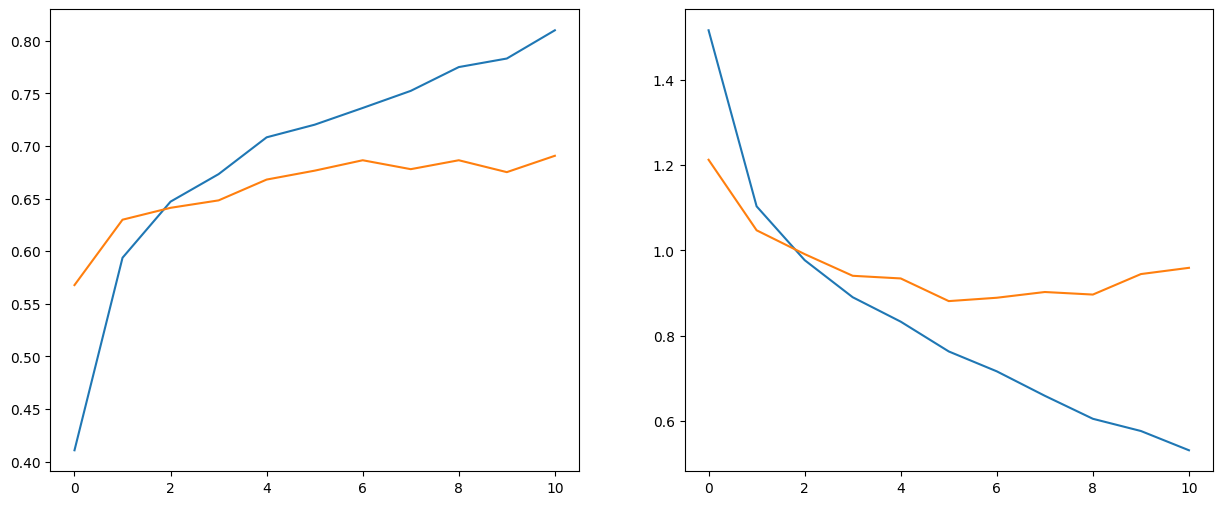

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])

### K-Fold test

### 10-Fold

In [ ]:
for i,(train_index, test_index) in enumerate(fold10_index) :
    model = lstm_tuner.hypermodel.build(best_hps)
    model.load_weights("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split50_50/lstm/bestweights.h5")
    checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/Skripsi/Revisi/split50_50/lstm/10-fold/bestweights{i}.h5",monitor='val_loss', verbose=0, restore_best_weights=True, mode='min', save_weights_only = True)
    model.fit(x=X_test[train_index], y = y_test[train_index], epochs = 50, validation_data = (X_test[test_index], y_test[test_index]), callbacks = [stop_early, checkpoint], verbose = False)

In [ ]:
lstm10_fold_performance = []

for i in range(10):
    model = lstm_tuner.hypermodel.build(best_hps)
    model.load_weights(f"/content/drive/MyDrive/Skripsi/Revisi/split50_50/lstm/10-fold/bestweights{i}.h5")
    model.compile(loss=lossfun, optimizer=optimizer, metrics = metrics)
    eval_metric = model.evaluate(X_test[fold10_index[i][1]],y_test[fold10_index[i][1]])
    y_pred = model.predict(X_test[fold10_index[i][1]])
    y_pred = [np.argmax(pred) for pred in y_pred]
    y_true = [np.argmax(true) for true in y_test[fold10_index[i][1]]]
    fold_metrics = {}
    fold_metrics["num_fold"] = i
    for j, metric_name in enumerate(model.metrics_names) :
        fold_metrics[metric_name] = eval_metric[j]
    macro_precision = precision_score(y_true, y_pred, average='macro')
    part_precision = precision_score(y_true, y_pred, average = None)
    macro_recall = recall_score(y_true, y_pred, average = 'macro')
    part_recall = recall_score(y_true, y_pred, average = None)
    macro_f1 = f1_score(y_true, y_pred, average = 'macro')
    part_f1 = f1_score(y_true, y_pred, average = None)
    fold_metrics["macro_precision"] = macro_precision
    fold_metrics["macro_recall"] = macro_recall
    fold_metrics["macro_f1"] = macro_f1
    fold_metrics["part_precision"] = part_precision.tolist()
    fold_metrics["part_recall"] = part_recall.tolist()
    fold_metrics["part_f1"] = part_f1.tolist()



    lstm10_fold_performance.append(fold_metrics)

12/12 [==============================] - 0s 4ms/step


In [ ]:
with open("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split50_50/lstm/lstm10_performance.json", "w") as js :
    json.dump(lstm10_fold_performance, js)

### 30 Fold

In [ ]:
for i,(train_index, test_index) in enumerate(fold30_index) :
    model = lstm_tuner.hypermodel.build(best_hps)
    model.load_weights("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split50_50/lstm/bestweights.h5")
    checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/Skripsi/Revisi/split50_50/lstm/30-fold/bestweights{i}.h5",monitor='val_loss', verbose=0, restore_best_weights=True, mode='min', save_weights_only = True)
    model.fit(x=X_test[train_index], y = y_test[train_index], epochs = 50, validation_data = (X_test[test_index], y_test[test_index]), callbacks = [stop_early, checkpoint], verbose = False)

In [ ]:
lstm30_fold_performance = []

for i in range(30):
    model = lstm_tuner.hypermodel.build(best_hps)
    model.load_weights(f"/content/drive/MyDrive/Skripsi/Revisi/split50_50/lstm/30-fold/bestweights{i}.h5")
    model.compile(loss=lossfun, optimizer=optimizer, metrics = metrics)
    eval_metric = model.evaluate(X_test[fold30_index[i][1]],y_test[fold30_index[i][1]])
    y_pred = model.predict(X_test[fold30_index[i][1]])
    y_pred = [np.argmax(pred) for pred in y_pred]
    y_true = [np.argmax(true) for true in y_test[fold30_index[i][1]]]
    fold_metrics = {}
    fold_metrics["num_fold"] = i
    for j, metric_name in enumerate(model.metrics_names) :
        fold_metrics[metric_name] = eval_metric[j]
    macro_precision = precision_score(y_true, y_pred, average='macro')
    part_precision = precision_score(y_true, y_pred, average = None)
    macro_recall = recall_score(y_true, y_pred, average = 'macro')
    part_recall = recall_score(y_true, y_pred, average = None)
    macro_f1 = f1_score(y_true, y_pred, average = 'macro')
    part_f1 = f1_score(y_true, y_pred, average = None)
    fold_metrics["macro_precision"] = macro_precision
    fold_metrics["macro_recall"] = macro_recall
    fold_metrics["macro_f1"] = macro_f1
    fold_metrics["part_precision"] = part_precision.tolist()
    fold_metrics["part_recall"] = part_recall.tolist()
    fold_metrics["part_f1"] = part_f1.tolist()



    lstm30_fold_performance.append(fold_metrics)

NameError: name 'lstm_tuner' is not defined

In [ ]:
with open("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split50_50/lstm/lstm30_performance.json", "w") as js :
    json.dump(lstm30_fold_performance, js)

## CNNLSTM

### Training Tuning

In [ ]:
cnnlstm_tuner = kt.Hyperband(CNNLSTMModel(),
                     objective = 'val_loss',
                     max_epochs = 50,
                     factor = 3,
                     overwrite = True,
                     directory = "/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split50_50/tuning",
                     project_name = "cnnlstm")

In [ ]:
stop_early = EarlyStopping(monitor='val_loss', patience = 5)


In [ ]:
cnnlstm_tuner.search(X_train, y_train, validation_split = 0.2, callbacks = [stop_early])

Trial 90 Complete [00h 00m 23s]
val_loss: 1.019451379776001

Best val_loss So Far: 0.9204381108283997
Total elapsed time: 00h 25m 19s


In [ ]:
best_hps = cnnlstm_tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split50_50/cnnlstm/bestweights.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto"
)

In [ ]:
model = cnnlstm_tuner.hypermodel.build(best_hps)
history = model.fit(X_train,y_train, epochs = 50, callbacks = [stop_early, checkpoint], validation_split = .2)

Epoch 1/50
89/89 [==============================] - 6s 31ms/step - loss: 1.6732 - accuracy: 0.3105 - val_loss: 1.4600 - val_accuracy: 0.4280
Epoch 2/50
89/89 [==============================] - 1s 13ms/step - loss: 1.4009 - accuracy: 0.4670 - val_loss: 1.2432 - val_accuracy: 0.5085
Epoch 3/50
89/89 [==============================] - 1s 12ms/step - loss: 1.2464 - accuracy: 0.5383 - val_loss: 1.1526 - val_accuracy: 0.5777
Epoch 4/50
89/89 [==============================] - 1s 14ms/step - loss: 1.1119 - accuracy: 0.5846 - val_loss: 1.0835 - val_accuracy: 0.6116
Epoch 5/50
89/89 [==============================] - 1s 14ms/step - loss: 1.0504 - accuracy: 0.6132 - val_loss: 1.0243 - val_accuracy: 0.6229
Epoch 6/50
89/89 [==============================] - 1s 15ms/step - loss: 1.0078 - accuracy: 0.6298 - val_loss: 1.0013 - val_accuracy: 0.6356
Epoch 7/50
89/89 [==============================] - 1s 11ms/step - loss: 0.9682 - accuracy: 0.6507 - val_loss: 1.0144 - val_accuracy: 0.6384
Epoch 8/50
89

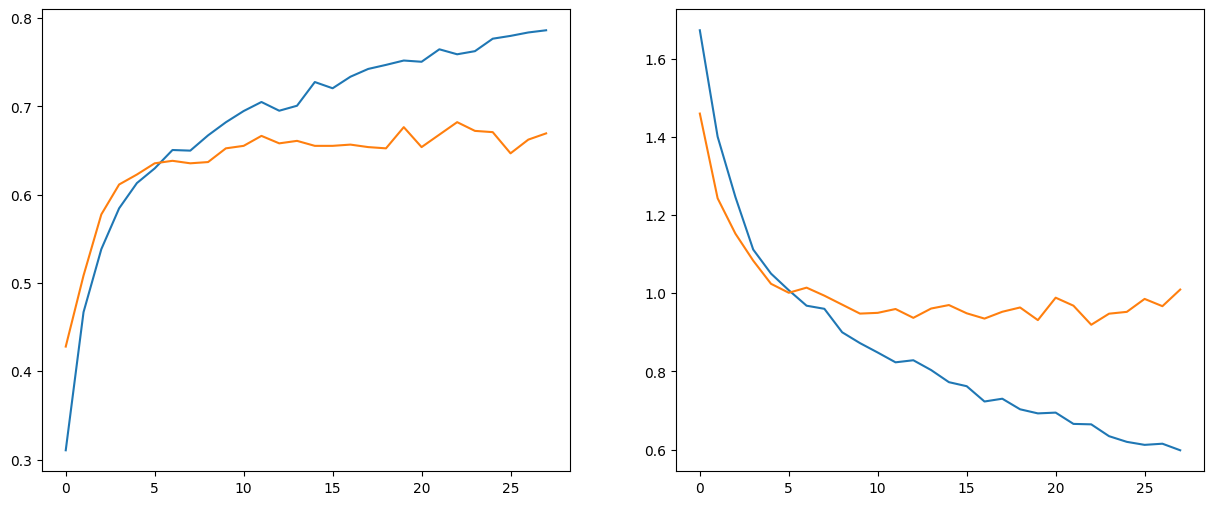

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])

### K-Fold test

#### 10-Fold

In [ ]:
for i,(train_index, test_index) in enumerate(fold10_index) :
    model = cnnlstm_tuner.hypermodel.build(best_hps)
    model.load_weights("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split50_50/cnnlstm/bestweights.h5")
    checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/Skripsi/Revisi/split50_50/lstm/10-fold/bestweights{i}.h5",monitor='val_loss', verbose=0, restore_best_weights=True, mode='min', save_weights_only = True)
    model.fit(x=X_test[train_index], y = y_test[train_index], epochs = 50, validation_data = (X_test[test_index], y_test[test_index]), callbacks = [stop_early, checkpoint], verbose = False)

In [ ]:
cnnlstm10_fold_performance = []

for i in range(10):
    model = cnnlstm_tuner.hypermodel.build(best_hps)
    model.load_weights(f"/content/drive/MyDrive/Skripsi/Revisi/split50_50/lstm/10-fold/bestweights{i}.h5")
    model.compile(loss=lossfun, optimizer=optimizer, metrics = metrics)
    eval_metric = model.evaluate(X_test[fold10_index[i][1]],y_test[fold10_index[i][1]])
    y_pred = model.predict(X_test[fold10_index[i][1]])
    y_pred = [np.argmax(pred) for pred in y_pred]
    y_true = [np.argmax(true) for true in y_test[fold10_index[i][1]]]
    fold_metrics = {}
    fold_metrics["num_fold"] = i
    for j, metric_name in enumerate(model.metrics_names) :
        fold_metrics[metric_name] = eval_metric[j]
    macro_precision = precision_score(y_true, y_pred, average='macro')
    part_precision = precision_score(y_true, y_pred, average = None)
    macro_recall = recall_score(y_true, y_pred, average = 'macro')
    part_recall = recall_score(y_true, y_pred, average = None)
    macro_f1 = f1_score(y_true, y_pred, average = 'macro')
    part_f1 = f1_score(y_true, y_pred, average = None)
    fold_metrics["macro_precision"] = macro_precision
    fold_metrics["macro_recall"] = macro_recall
    fold_metrics["macro_f1"] = macro_f1
    fold_metrics["part_precision"] = part_precision.tolist()
    fold_metrics["part_recall"] = part_recall.tolist()
    fold_metrics["part_f1"] = part_f1.tolist()



    cnnlstm10_fold_performance.append(fold_metrics)

12/12 [==============================] - 0s 5ms/step


#### 30-fold

In [ ]:
for i,(train_index, test_index) in enumerate(fold30_index) :
    model = cnnlstm_tuner.hypermodel.build(best_hps)
    model.load_weights("/content/drive/MyDrive/Skripsi/emotion_detection_CNN-LSTM/Revisi/split50_50/cnnlstm/bestweights.h5")
    checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/Skripsi/Revisi/split50_50/cnnlstm/30-fold/bestweights{i}.h5",monitor='val_loss', verbose=0, restore_best_weights=True, mode='min', save_weights_only = True)
    model.fit(x=X_test[train_index], y = y_test[train_index], epochs = 50, validation_data = (X_test[test_index], y_test[test_index]), callbacks = [stop_early, checkpoint], verbose = False)

In [ ]:
cnnlstm30_fold_performance = []

for i in range(30):
    model = cnnlstm_tuner.hypermodel.build(best_hps)
    model.load_weights(f"/content/drive/MyDrive/Skripsi/Revisi/split50_50/cnnlstm/30-fold/bestweights{i}.h5")
    model.compile(loss=lossfun, optimizer=optimizer, metrics = metrics)
    eval_metric = model.evaluate(X_test[fold30_index[i][1]],y_test[fold30_index[i][1]])
    y_pred = model.predict(X_test[fold30_index[i][1]])
    y_pred = [np.argmax(pred) for pred in y_pred]
    y_true = [np.argmax(true) for true in y_test[fold30_index[i][1]]]
    fold_metrics = {}
    fold_metrics["num_fold"] = i
    for j, metric_name in enumerate(model.metrics_names) :
        fold_metrics[metric_name] = eval_metric[j]
    macro_precision = precision_score(y_true, y_pred, average='macro')
    part_precision = precision_score(y_true, y_pred, average = None)
    macro_recall = recall_score(y_true, y_pred, average = 'macro')
    part_recall = recall_score(y_true, y_pred, average = None)
    macro_f1 = f1_score(y_true, y_pred, average = 'macro')
    part_f1 = f1_score(y_true, y_pred, average = None)
    fold_metrics["macro_precision"] = macro_precision
    fold_metrics["macro_recall"] = macro_recall
    fold_metrics["macro_f1"] = macro_f1
    fold_metrics["part_precision"] = part_precision.tolist()
    fold_metrics["part_recall"] = part_recall.tolist()
    fold_metrics["part_f1"] = part_f1.tolist()



    cnnlstm30_fold_performance.append(fold_metrics)